#### Αιμιλιος Δραγκινης ημμυ 9364

Η παρουσα εγασια υλοποιει ενα autoencoder neural net το οποιο παιρνει σαν εισοδο μια εικονα 28x28 που απεικονιζει ενα ψηφιο (mnist) και βγαζει το αμεσως επομενο ψηφιο στην εξοδο.

#### Autoencoder


In [1]:
import torch
from torchvision import datasets        
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

/home/millliono/miniconda3/envs/dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST(root='./data', train=True,
                          transform=transform, download=True)
testset = datasets.MNIST(root='./data', train=False,
                         transform=transform, download=True)

print("trainset: ", len(trainset))
print("testset: ", len(testset))
# print(trainset[123])

batch_size = 32
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=6)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=True, num_workers=6)

for X, y in testloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

trainset:  60000
testset:  10000
Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64


The digit images used as output targets during training.


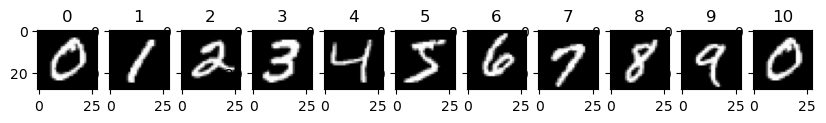

In [3]:
# construct digits list that contains each digit's image representation. 
# digits' items will be used as training targets

digits = []
for i in range(10):
    for example in trainset:
        if example[1] == i:
            digits.append(example[0])
            break
digits.append(digits[0])

# target digits visualization
n = 11 
print("The digit images used as output targets during training.")
plt.figure(figsize=(10, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(digits[i].reshape(28,28))
    plt.title(i)
    plt.gray()

In [4]:
# returns the target output for a batch (next digit)
def get_target(X, y, digits):
    target = []
    for i in range(len(y)):
        for j in range(10):
            if y[i] == j:
                target.append(digits[j+1])
                break
    return torch.stack(target, dim=0)

In [5]:
from torch import nn
from torch import optim
import torch.nn.functional as F

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
             nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 784),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [7]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, get_target(X, y, digits).reshape(-1, 28*28))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss = loss.item()
            current = batch * len(X)
            print(f"loss(batch): {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}  (batch_size={batch_size}, lr={lr})\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)

Epoch 1  (batch_size=32, lr=0.001)
-------------------------------
loss(batch): 0.229584  [    0/60000]
loss(batch): 0.058254  [ 3200/60000]
loss(batch): 0.058939  [ 6400/60000]
loss(batch): 0.042861  [ 9600/60000]
loss(batch): 0.038691  [12800/60000]
loss(batch): 0.028459  [16000/60000]
loss(batch): 0.019874  [19200/60000]
loss(batch): 0.016952  [22400/60000]
loss(batch): 0.013495  [25600/60000]
loss(batch): 0.014048  [28800/60000]
loss(batch): 0.012252  [32000/60000]
loss(batch): 0.002413  [35200/60000]
loss(batch): 0.013049  [38400/60000]
loss(batch): 0.005957  [41600/60000]
loss(batch): 0.005091  [44800/60000]
loss(batch): 0.010913  [48000/60000]
loss(batch): 0.006080  [51200/60000]
loss(batch): 0.003102  [54400/60000]
loss(batch): 0.009147  [57600/60000]
Epoch 2  (batch_size=32, lr=0.001)
-------------------------------
loss(batch): 0.006422  [    0/60000]
loss(batch): 0.005584  [ 3200/60000]
loss(batch): 0.008772  [ 6400/60000]
loss(batch): 0.006182  [ 9600/60000]
loss(batch): 0.

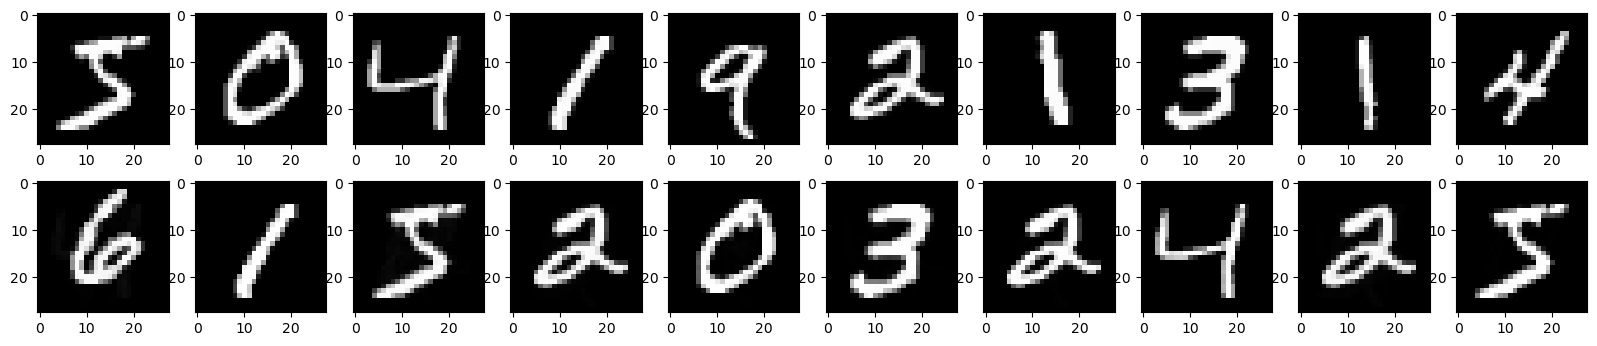

In [10]:
# visualization
import matplotlib.pyplot as plt

n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(trainset[i][0].reshape(28,28))
    plt.gray()

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(model(trainset[i][0].to(device)).cpu().detach().numpy().reshape(28,28))
    plt.gray()
plt.show()


####  PCA

This section of code is used to compare the performance of the autoencoder and pca with the same dimensionality reduction. 

In [11]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

X,y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [12]:
# Fit a PCA model to the data and transform the data
pca = PCA(n_components=32)
X_transformed = pca.fit_transform(X)

# Inverse transform the data to reconstruct the original data
X_reconstructed = pca.inverse_transform(X_transformed)

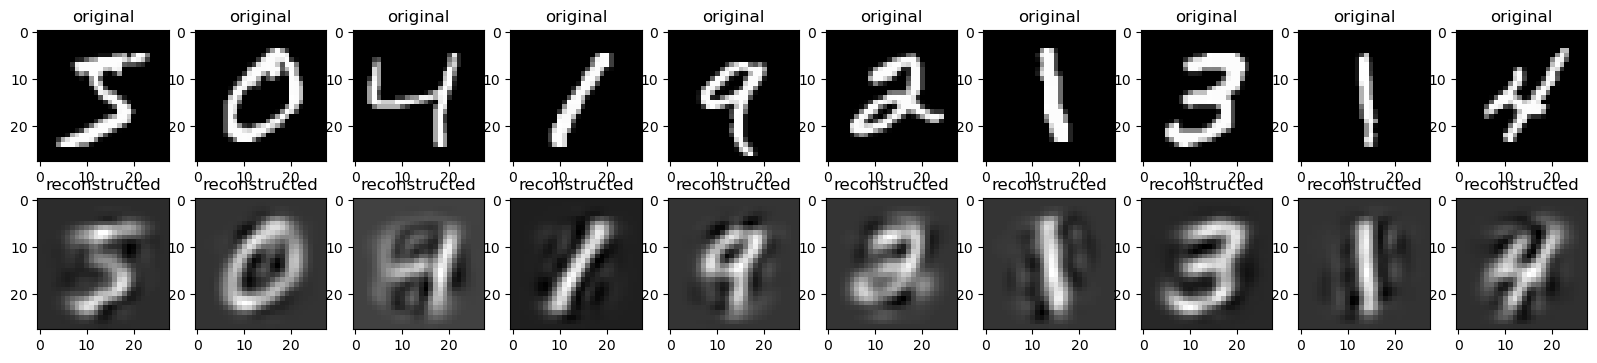

In [13]:
# visualization
n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X[i].reshape(28,28))
    plt.title("original")
    plt.gray()

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_reconstructed[i].reshape(28, 28))
    plt.title("reconstructed")
    plt.gray()
plt.show()